# Projekt końcowy

## Autorzy

- Filip Wielgosz
- Hubert Lewandowski

## Krok 1: Wczytanie danych

In [62]:
import pandas as pd

df = pd.read_csv('clean_cafe_sales.csv')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Year,Month,Day
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023,9,8
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023,5,16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023,7,19
3,TXN_7034554,Salad,2,5.0,10.0,Credit Card,In-store,2023,4,27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023,6,11


## Krok 2. Wykonanie analiz opisowych

### Pytanie

Jak zmieniają się średnie wydatki klientów na poszczególne produkty w zależności od miesiąca?

#### Powód

Pozwoli to zbadać, na które z produktów jest wzmożony popyt, a na które go nie ma i można zmniejszyć ilość w magazynie.

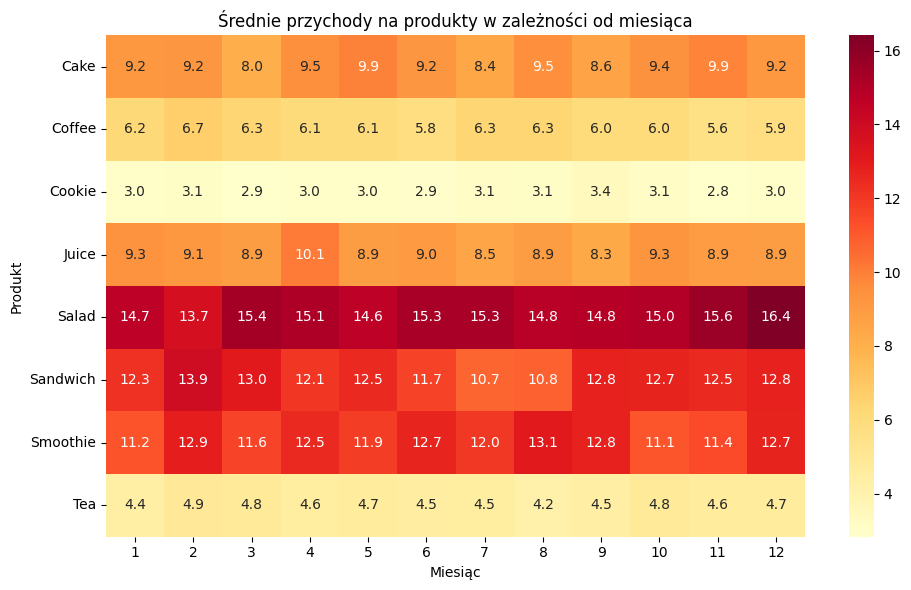

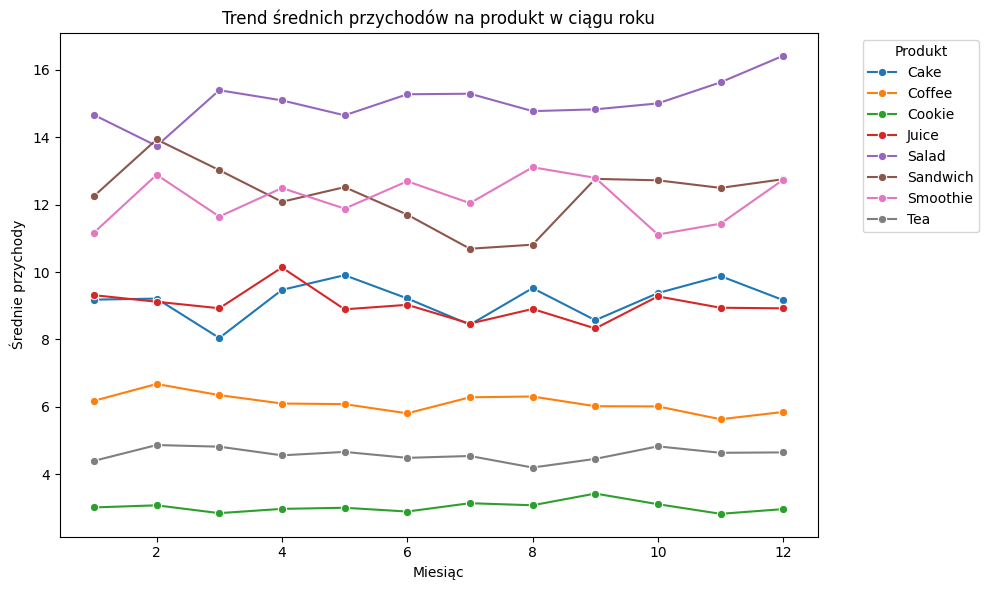

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

monthly_item_avg = df.groupby(["Month", "Item"])["Total Spent"].mean().reset_index()

# Średnie wydatki wg miesiąca i produktu
pivot_table = monthly_item_avg.pivot(index="Item", columns="Month", values="Total Spent")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Średnie przychody na produkty w zależności od miesiąca")
plt.xlabel("Miesiąc")
plt.ylabel("Produkt")
plt.tight_layout()
plt.show()

# Trend średnich wydatków na produkt wg miesiąca
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_item_avg, x="Month", y="Total Spent", hue="Item", marker="o")
plt.title("Trend średnich przychodów na produkt w ciągu roku")
plt.xlabel("Miesiąc")
plt.ylabel("Średnie przychody")
plt.legend(title="Produkt", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### Odpowiedź

Wyniki pokazują, że produkty takie jak **sałatki**, **kanapki** i **smoothie** mają najwyższe średnie przychody.

Salad rośnie systematycznie w ciągu roku, osiągając szczyt w grudniu.

Produkty jak kawa, ciastka czy herbata utrzymują stabilne, niskie przychody niezależnie od miesiąca.

### Pytanie

Które konkretne produkty są bardziej popularne na miejscu i na wynos w danym miesiącu?

#### Powód

Pozwoli to przygotować logistykę oraz przestrzeń magazynową na opakowania na wynos.

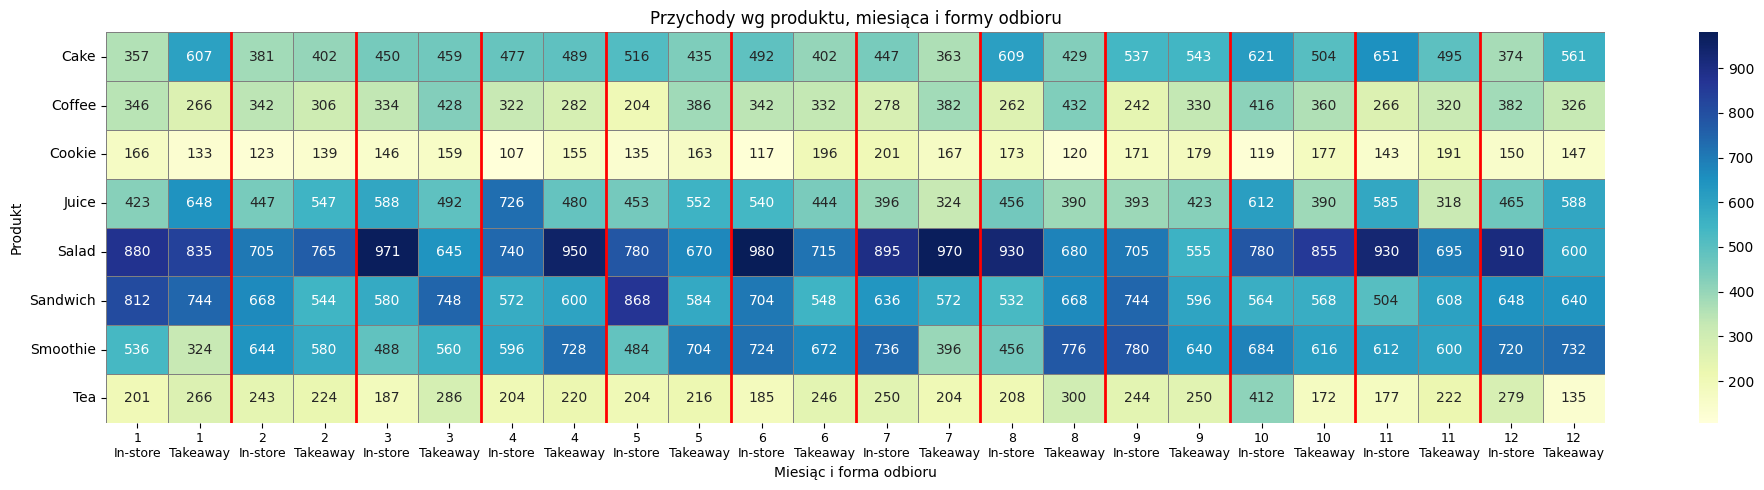

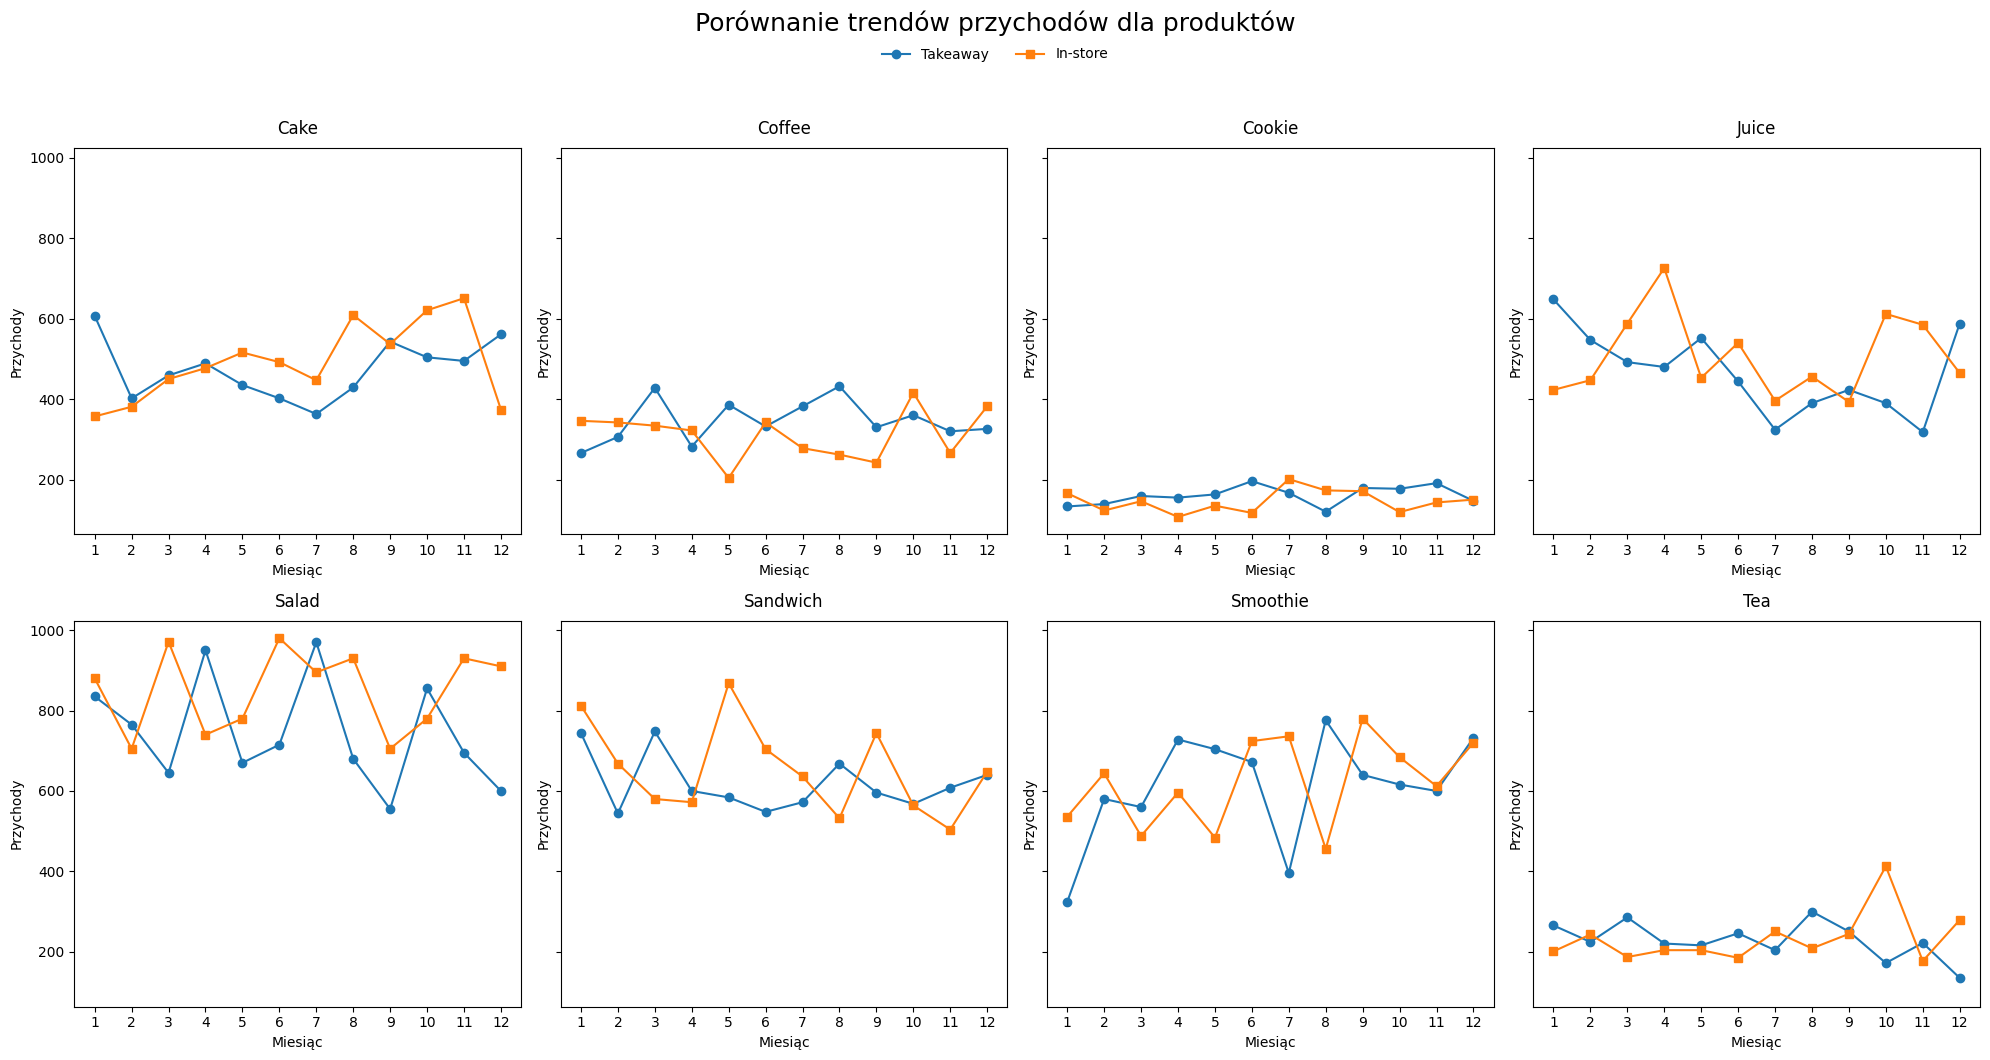

In [64]:
pivot_all = df.pivot_table(
    index="Item",
    columns=["Month", "Location"],
    values="Total Spent",
    aggfunc="sum"
).fillna(0)
plt.figure(figsize=(20, 5))
ax = sns.heatmap(pivot_all, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')

# Etykiety
labels = [f"{month}\n{loc}" for month, loc in pivot_all.columns]
ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=9)

# Linie oddzielające
n_locations = df["Location"].nunique()
months = sorted(df["Month"].unique())
for i in range(1, len(months)):
    ax.axvline(i * n_locations, color='red', lw=2)

# Nazwy osi i tytuł
ax.set_title("Przychody wg produktu, miesiąca i formy odbioru")
ax.set_xlabel("Miesiąc i forma odbioru")
ax.set_ylabel("Produkt")
plt.tight_layout()
plt.show()



months = sorted(df["Month"].unique())
items = sorted(df["Item"].unique())

takeaway = df[df["Location"] == "Takeaway"]
in_store = df[df["Location"] == "In-store"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for ax, item in zip(axes, items):
    t = takeaway[takeaway.Item == item].groupby("Month")["Total Spent"].sum().reindex(months, fill_value=0)
    i = in_store[in_store.Item == item].groupby("Month")["Total Spent"].sum().reindex(months, fill_value=0)
    ax.plot(months, t.values, marker='o', label="Takeaway")
    ax.plot(months, i.values, marker='s', label="In-store")
    ax.set_title(item, pad=10)
    ax.set_xlabel("Miesiąc")
    ax.set_xticks(months)
    ax.set_ylabel("Przychody")

# Usuń wszystkie lokalne legendy
for ax in axes:
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Dodaj wspólną legendę na górze
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.03))

# Przesuń suptitle wyżej:
fig.suptitle(
    "Porównanie trendów przychodów dla produktów", 
    fontsize=18, y=1.055
)

plt.tight_layout()
plt.show()

### Odpowiedź

Analiza nie wykazała wyraźnych i spójnych wzorców preferencji klientów względem formy odbioru (na miejscu czy na wynos).

Wzorce przychodów są nieregularne i silnie zmienne, co uniemożliwia jednoznaczne wnioski logistyczne.

### Pytanie

Jakie cechy transakcji są ze sobą powiązane i mogą wpływać na wysokość wydatków klienta?

### Powód

Wiedza na temat zależności w wykonanych tranzakcjach pozwoli lepiej dostosować oferty (np. promocyjne zestawy) dla zwiększenia sprzedaży.

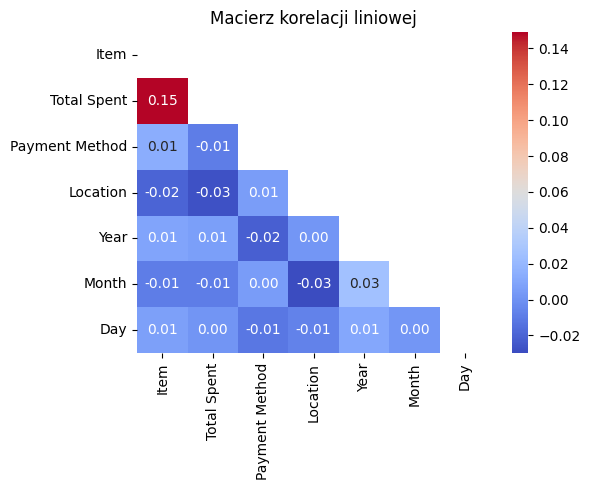

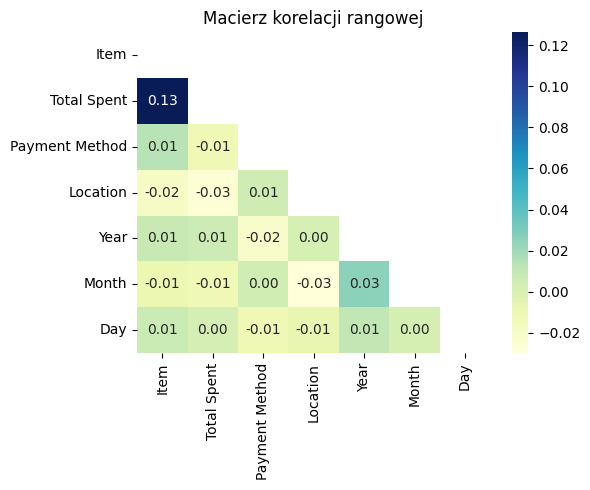

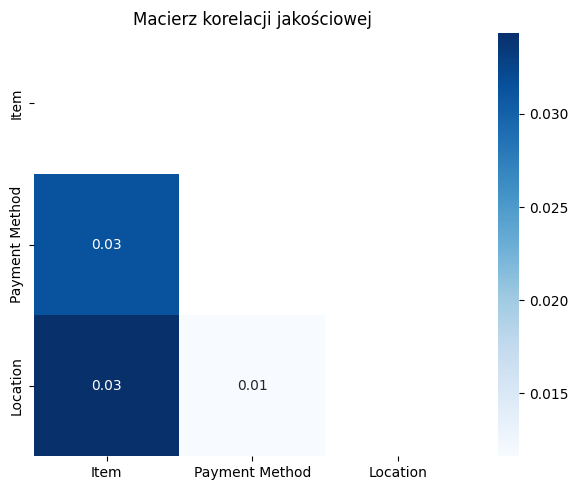

In [ ]:
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder

# One-hot encoding dla tekstowych danych
columns = [col for col in df.columns if col not in ["Transaction ID", "Price Per Unit", "Quantity"]]
cat_cols = ["Item", "Payment Method", "Location"]

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 1. Korelacja Pearsona
pearson_corr = df[columns].corr(method="pearson")
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

plt.figure(figsize=(6, 5))
sns.heatmap(pearson_corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji liniowej")
plt.tight_layout()
plt.show()

# 2. Korelacja rangowa (Spearman)
spearman_corr = df[columns].corr(method="spearman")
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
plt.figure(figsize=(6, 5))
sns.heatmap(spearman_corr, mask=mask, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Macierz korelacji rangowej")
plt.tight_layout()
plt.show()

# 3. Korelacja jakościowa (Cramér's V)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
mask = np.triu(np.ones_like(cramer_matrix, dtype=bool))

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramer_matrix = cramer_matrix.astype(float)
plt.figure(figsize=(6, 5))
sns.heatmap(cramer_matrix, mask=mask, annot=True, cmap="Blues", fmt=".2f")
plt.title("Macierz korelacji jakościowej")
plt.tight_layout()
plt.show()

Z przeprowadzonych analiz korelacji wynika, że zależności między cechami transakcji są bardzo słabe.

Jedyną minimalnie silniejszą relację obserwujemy między **typem produktu a całkowitą kwotą wydatku**, ale nadal jest ona niewielka.

Podsumowując, cechy transakcji są raczej niezależne, co może świadczyć o różnorodności zachowań klientów i braku wyraźnych wzorców wpływających na wydatki.